In [1]:
# ============================================================
# 0) SETUP & REPRODUCIBILITY
# ============================================================
import sys
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import json
import time
from scipy.special import softmax

# Helper per stampare versioni
def import_module_version(module_name):
    """Helper per stampare versioni"""
    import importlib
    module = importlib.import_module(module_name)
    return module.__version__

# Seed per riproducibilità
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Costanti notebook
MODEL_ID = "cardiffnlp/twitter-roberta-base-sentiment-latest"
DATASET_ID = "tweet_eval"
DATASET_SUBSET = "sentiment"
SPLIT = "test"

# Stampa versioni
print("=" * 50)
print("ENVIRONMENT")
print("=" * 50)
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Transformers: {import_module_version('transformers')}")
print(f"Datasets: {import_module_version('datasets')}")
print(f"Device: CPU (inference-only)")
print(f"Seed: {SEED}")
print("=" * 50)
print("CONFIG")
print("=" * 50)
print(f"Model: {MODEL_ID}")
print(f"Dataset: {DATASET_ID}/{DATASET_SUBSET}")
print(f"Split: {SPLIT}")
print("=" * 50)

c:\Users\cpmin\Projects\sentimentops\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ENVIRONMENT
Python: 3.13.11 (tags/v3.13.11:6278944, Dec  5 2025, 16:26:58) [MSC v.1944 64 bit (AMD64)]
PyTorch: 2.9.1+cpu
Transformers: 4.57.6
Datasets: 4.5.0
Device: CPU (inference-only)
Seed: 42
CONFIG
Model: cardiffnlp/twitter-roberta-base-sentiment-latest
Dataset: tweet_eval/sentiment
Split: test


In [2]:
# ============================================================
# 1) LOAD DATASET
# ============================================================
print("Caricamento dataset TweetEval sentiment...")
dataset = load_dataset(DATASET_ID, DATASET_SUBSET)

print(f"\nStruttura dataset:")
print(dataset)

print(f"\nSplit disponibili: {list(dataset.keys())}")
print(f"Dimensione test set: {len(dataset['test'])}")

# Visualizziamo un esempio
print(f"\nEsempio dal test set:")
print(dataset['test'][0])

# Label mapping (TweetEval sentiment: 0=negative, 1=neutral, 2=positive)
LABEL_NAMES = ["negative", "neutral", "positive"]
print(f"\nLabel mapping: {dict(enumerate(LABEL_NAMES))}")

Caricamento dataset TweetEval sentiment...

Struttura dataset:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Split disponibili: ['train', 'test', 'validation']
Dimensione test set: 12284

Esempio dal test set:
{'text': "@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that.", 'label': 1}

Label mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [3]:
# ============================================================
# 2) LOAD MODEL & TOKENIZER
# ============================================================
print(f"Caricamento modello: {MODEL_ID}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
config = AutoConfig.from_pretrained(MODEL_ID)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID)

# Modalità evaluation (disabilita dropout)
model.eval()

print(f"\nModello caricato!")
print(f"Label config dal modello: {config.id2label}")
print(f"Numero parametri: {model.num_parameters():,}")

Caricamento modello: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Modello caricato!
Label config dal modello: {0: 'negative', 1: 'neutral', 2: 'positive'}
Numero parametri: 124,647,939


In [4]:
# ============================================================
# 4) PREPROCESSING (Twitter-specific)
# ============================================================
def preprocess_tweet(text):
    """
    Preprocessing specifico per tweet (standard cardiffnlp):
    - Sostituisce @username con @user
    - Sostituisce URL con http
    """
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Test preprocessing
test_text = "@john Check this https://example.com it's amazing!"
print(f"Originale:     {test_text}")
print(f"Preprocessato: {preprocess_tweet(test_text)}")

Originale:     @john Check this https://example.com it's amazing!
Preprocessato: @user Check this http it's amazing!


In [5]:
# ============================================================
# 5) INFERENCE CON BATCHING
# ============================================================
# Configurazione
BATCH_SIZE = 32
MAX_LENGTH = 128

# Verifica allineamento label mapping
EXPECTED_LABELS = {0: "negative", 1: "neutral", 2: "positive"}
assert config.id2label == EXPECTED_LABELS, \
    f"Label mismatch! Modello: {config.id2label}, Atteso: {EXPECTED_LABELS}"
print(f"✓ Label mapping verificato: {config.id2label}")

# Prepara dati
test_data = dataset['test']
all_texts = [preprocess_tweet(example['text']) for example in test_data]
true_labels = np.array([example['label'] for example in test_data])

print(f"\nAvvio inference su {len(all_texts)} esempi...")
print(f"Batch size: {BATCH_SIZE}, Max length: {MAX_LENGTH}")

predictions = []
all_probs = []
truncated_count = 0

start_time = time.time()

with torch.no_grad():
    for i in range(0, len(all_texts), BATCH_SIZE):
        batch_texts = all_texts[i:i + BATCH_SIZE]
        
        # Tokenizzazione batch
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='pt'
        )
        
        # Conta truncation
        for ids in encoded['input_ids']:
            if ids[-1] != tokenizer.pad_token_id and len(ids) == MAX_LENGTH:
                truncated_count += 1
        
        # Inference
        output = model(**encoded)
        probs = torch.softmax(output.logits, dim=-1).detach().cpu().numpy()
        preds = np.argmax(probs, axis=-1)
        
        predictions.extend(preds)
        all_probs.extend(probs)
        
        # Progress ogni 100 batch
        if ((i // BATCH_SIZE) + 1) % 100 == 0:
            print(f"  Batch {(i // BATCH_SIZE) + 1}/{(len(all_texts) // BATCH_SIZE) + 1}")

inference_time = time.time() - start_time
predictions = np.array(predictions)
all_probs = np.array(all_probs)

# Statistiche
truncation_rate = truncated_count / len(all_texts)
throughput = len(all_texts) / inference_time

print(f"\n✓ Inference completata!")
print(f"  Tempo totale: {inference_time:.2f} secondi")
print(f"  Throughput: {throughput:.2f} esempi/secondo")
print(f"  Truncation rate: {truncation_rate:.4f} ({truncated_count}/{len(all_texts)})")

✓ Label mapping verificato: {0: 'negative', 1: 'neutral', 2: 'positive'}

Avvio inference su 12284 esempi...
Batch size: 32, Max length: 128
  Batch 100/384
  Batch 200/384
  Batch 300/384

✓ Inference completata!
  Tempo totale: 1377.51 secondi
  Throughput: 8.92 esempi/secondo
  Truncation rate: 0.0000 (0/12284)


In [6]:
# ============================================================
# 6) CALCOLO METRICHE
# ============================================================
# Accuracy
accuracy = accuracy_score(true_labels, predictions)

# Precision, Recall, F1 (macro e per classe)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    true_labels, predictions, average='macro'
)
precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    true_labels, predictions, average=None, labels=[0, 1, 2]
)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])

# Risultati in dizionario (per export)
metrics_dict = {
    "eval_accuracy": round(accuracy, 4),
    "eval_precision_macro": round(precision_macro, 4),
    "eval_recall_macro": round(recall_macro, 4),
    "eval_f1_macro": round(f1_macro, 4),
    "perf_inference_time_sec": round(inference_time, 2),
    "perf_throughput_sps": round(throughput, 2),
    "perf_truncation_rate": round(truncation_rate, 4),
    "config_batch_size": BATCH_SIZE,
    "config_max_length": MAX_LENGTH,
    "config_num_samples": len(true_labels),
}

# Aggiungi metriche per classe
for i, label in enumerate(LABEL_NAMES):
    metrics_dict[f"eval_f1_{label}"] = round(f1_per_class[i], 4)
    metrics_dict[f"eval_precision_{label}"] = round(precision_per_class[i], 4)
    metrics_dict[f"eval_recall_{label}"] = round(recall_per_class[i], 4)
    metrics_dict[f"eval_support_{label}"] = int(support[i])

# Stampa risultati
print("=" * 50)
print("RISULTATI BASELINE")
print("=" * 50)
print(f"\nAccuracy:         {accuracy:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1-Score (macro):  {f1_macro:.4f}")

print(f"\nMetriche per classe:")
print("-" * 50)
for i, label in enumerate(LABEL_NAMES):
    print(f"  {label:10s}: P={precision_per_class[i]:.4f}  R={recall_per_class[i]:.4f}  F1={f1_per_class[i]:.4f}  Support={support[i]}")

RISULTATI BASELINE

Accuracy:         0.7218
Precision (macro): 0.7187
Recall (macro):    0.7349
F1-Score (macro):  0.7240

Metriche per classe:
--------------------------------------------------
  negative  : P=0.6895  R=0.8066  F1=0.7435  Support=3972
  neutral   : P=0.7566  R=0.6576  F1=0.7036  Support=5937
  positive  : P=0.7101  R=0.7406  F1=0.7251  Support=2375


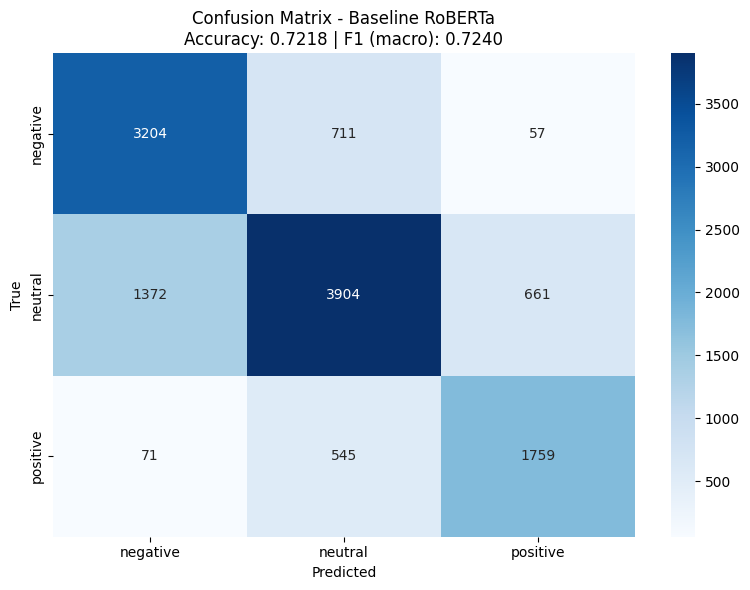

✓ Salvato: artifacts/baseline/confusion_matrix.png
✓ Salvato: artifacts/baseline/metrics.json
✓ Salvato: artifacts/baseline/confusion_matrix.csv
✓ Salvato: artifacts/baseline/classification_report.csv

✓ Tutti gli artifacts salvati in: artifacts/baseline/


In [ ]:
# ============================================================
# 7) VISUALIZZAZIONE & EXPORT ARTIFACTS
# ============================================================
import os

# Crea directory artifacts
ARTIFACTS_DIR = "../artifacts/baseline"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# 1. Confusion Matrix Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion Matrix - Baseline RoBERTa\nAccuracy: {accuracy:.4f} | F1 (macro): {f1_macro:.4f}')
plt.tight_layout()

cm_png_path = f"{ARTIFACTS_DIR}/confusion_matrix.png"
plt.savefig(cm_png_path, dpi=150)
plt.show()
print(f"✓ Salvato: {cm_png_path}")

# 2. Metrics JSON
metrics_json_path = f"{ARTIFACTS_DIR}/metrics.json"
with open(metrics_json_path, 'w') as f:
    json.dump(metrics_dict, f, indent=2)
print(f"✓ Salvato: {metrics_json_path}")

# 3. Confusion Matrix CSV
cm_df = pd.DataFrame(cm, index=LABEL_NAMES, columns=LABEL_NAMES)
cm_csv_path = f"{ARTIFACTS_DIR}/confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"✓ Salvato: {cm_csv_path}")

# 4. Classification Report CSV
report_df = pd.DataFrame({
    'class': LABEL_NAMES,
    'precision': precision_per_class,
    'recall': recall_per_class,
    'f1': f1_per_class,
    'support': support
})
report_csv_path = f"{ARTIFACTS_DIR}/classification_report.csv"
report_df.to_csv(report_csv_path, index=False)
print(f"✓ Salvato: {report_csv_path}")

print(f"\n✓ Tutti gli artifacts salvati in: {ARTIFACTS_DIR}/")

In [ ]:
# ============================================================
# 8) SET UP MLFLOW
# ============================================================
# MLflow setup - file-based storage
import mlflow

# MLflow setup - file-based storage (root del progetto)
MLFLOW_TRACKING_URI = "file:../mlruns"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"MLflow tracking: {mlflow.get_tracking_uri()}")

MLflow tracking: file:../mlruns


In [26]:
"""
Notebook: 01_baseline_roberta_inference_eval.ipynb
"""
import sys
import os
import numpy as np
import pandas as pd
import torch
import json
import time
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# MLflow setup - file-based storage (root del progetto)
MLFLOW_TRACKING_URI = "file:../mlruns"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Costanti
MODEL_ID = "cardiffnlp/twitter-roberta-base-sentiment-latest"
DATASET_ID = "tweet_eval"
DATASET_SUBSET = "sentiment"
SPLIT = "test"
LABEL_NAMES = ["negative", "neutral", "positive"]
BATCH_SIZE = 32
MAX_LENGTH = 128

print("=" * 50)
print("SETUP COMPLETATO")
print("=" * 50)
print(f"MLflow tracking: {mlflow.get_tracking_uri()}")
print(f"Model: {MODEL_ID}")




SETUP COMPLETATO
MLflow tracking: file:../mlruns
Model: cardiffnlp/twitter-roberta-base-sentiment-latest


In [ ]:

# ============================================================
# 9 CARICA RISULTATI PRECEDENTI (salta inferenza)
# ============================================================
print("Caricamento risultati salvati...")

# Carica metriche baseline
with open("../artifacts/baseline/metrics.json", 'r') as f:
    metrics_dict = json.load(f)

# Carica confusion matrix
cm_df = pd.read_csv("../artifacts/baseline/confusion_matrix.csv", index_col=0)
cm = cm_df.values

# Carica golden set
golden_set_df = pd.read_csv("../artifacts/golden/golden_set.csv")
golden_pred_df = pd.read_csv("../artifacts/golden/predictions/golden_predictions_baseline.csv")

# Estrai valori
accuracy = metrics_dict['eval_accuracy']
f1_macro = metrics_dict['eval_f1_macro']
precision_macro = metrics_dict['eval_precision_macro']
recall_macro = metrics_dict['eval_recall_macro']
inference_time = metrics_dict['perf_inference_time_sec']

print(f"✓ Metriche caricate")
print(f"  Accuracy: {accuracy}")
print(f"  F1 Macro: {f1_macro}")
print(f"✓ Confusion matrix caricata")
print(f"✓ Golden set caricato ({len(golden_set_df)} samples)")

Caricamento risultati salvati...
✓ Metriche caricate
  Accuracy: 0.7218
  F1 Macro: 0.724
✓ Confusion matrix caricata
✓ Golden set caricato (100 samples)


In [ ]:
# ============================================================
# 10 MLFLOW LOGGING - BASELINE
# ============================================================
EXPERIMENT_NAME = "sentimentops-baseline"
RUN_NAME = "roberta-twitter-baseline-v1"

mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME) as baseline_run:
    # Parametri
    mlflow.log_param("model_id", MODEL_ID)
    mlflow.log_param("dataset", f"{DATASET_ID}/{DATASET_SUBSET}")
    mlflow.log_param("split", SPLIT)
    mlflow.log_param("seed", SEED)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("max_length", MAX_LENGTH)
    
    # Metriche
    for key, value in metrics_dict.items():
        if key.startswith("eval_") or key.startswith("perf_"):
            mlflow.log_metric(key, value)
    
    # Artifacts
    mlflow.log_artifacts("../artifacts/baseline", artifact_path="baseline")
    
    BASELINE_RUN_ID = baseline_run.info.run_id

c:\Users\cpmin\Projects\sentimentops\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
Traceback (most recent call last):
  File "c:\Users\cpmin\Projects\sentimentops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 379, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\cpmin\Projects\sentimentops\.venv\Lib\site-packages\mlflow\store\tracking\file_store.py", line 477, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  Fi

BASELINE LOGGATO
Experiment: sentimentops-baseline
Run ID: b351916ee9fa4c0484508b2f19f78c41


In [ ]:
# ============================================================
# 11 MLFLOW LOGGING - GOLDEN SET
# ============================================================
# ============================================================
# 11 MLFLOW LOGGING - GOLDEN SET
# ============================================================
golden_labels = golden_set_df['label'].values
golden_preds = golden_pred_df['pred'].values
golden_accuracy = accuracy_score(golden_labels, golden_preds)
golden_macro_f1 = f1_score(golden_labels, golden_preds, average='macro')

with mlflow.start_run(run_name="golden-set-export") as golden_run:
    mlflow.set_tag("parent_baseline_run_id", BASELINE_RUN_ID)
    mlflow.set_tag("golden_size", "100")
    mlflow.set_tag("seed", str(SEED))
    
    mlflow.log_metric("eval_golden_accuracy", golden_accuracy)
    mlflow.log_metric("eval_golden_macro_f1", golden_macro_f1)
    
    mlflow.log_artifacts("../artifacts/golden", artifact_path="golden")
    
    GOLDEN_RUN_ID = golden_run.info.run_id

print("=" * 50)
print("GOLDEN SET LOGGATO")
print("=" * 50)
print(f"Run ID: {GOLDEN_RUN_ID}")
print(f"Golden Accuracy: {golden_accuracy:.4f}")
print(f"Golden Macro-F1: {golden_macro_f1:.4f}")

GOLDEN SET LOGGATO
Run ID: bbd7385e8587497d894160641536ddfc
Golden Accuracy: 0.6600
Golden Macro-F1: 0.6720
